<a href="https://colab.research.google.com/github/drcapybara/DP-DGA/blob/main/DP_Experiments_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-privacy

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

import pandas as pd
import numpy as np
import pyarrow
import pyarrow.parquet as pq

import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import gc
import os
from time import sleep
from keras.models import model_from_json

dir='/content/drive/MyDrive/DGA_PPML/'
dir_model = dir + 'cnn_binary_all/'
dataset='all_dataset'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 13 03:59:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
X_train = pd.read_parquet(dir+dataset+'/binary/X_train.parquet', engine='pyarrow')
X_test = pd.read_parquet(dir+dataset+'/binary/X_test.parquet', engine='pyarrow')
y_train = pd.read_parquet(dir+dataset+'/binary/y_train.parquet', engine='pyarrow')
y_test = pd.read_parquet(dir+dataset+'/binary/y_test.parquet', engine='pyarrow')

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


print("total elements in dataset:", np.shape(X_train)[0] + np.shape(X_test)[0])

X_train (1616000, 64)
X_test (404000, 64)
y_train (1616000, 1)
y_test (404000, 1)
total elements in dataset: 2020000


In [ ]:
# experiments
noise_multiplier = 0.0
epochs = 30
batch_size = 128
learning_rate = 0.0001
num_microbatches = 1
l2_norm_clip = 1

#  model construction
# noise_multiplier = 1
# epochs = 1
# batch_size = 12800
# learning_rate = 0.0001
# num_microbatches = 1
# l2_norm_clip = 1

model_loss = []
model_val_loss = []
loss_delta = []

model_acc = []
model_val_acc = []
acc_delta = []

eps_values = []

In [ ]:
# CNN training model 
def train():

  optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  loss = tf.keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.0, axis=-1,
      reduction=tf.losses.Reduction.NONE, name='binary_crossentropy'
  )

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Embedding(input_dim=128, output_dim=128, input_length=64))

  print("Input shape before embedding: ", model.input_shape)
  print("Input shape after embedding: ", model.output_shape)
  print("Shape before Conv1D: ", model.output_shape)

  model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=10, activation = 'relu', input_shape=(64,1)))

  print("Shape after Conv1D: ", model.output_shape)
  print("Shape before maxPooling1d: ", model.output_shape)

  model.add(tf.keras.layers.MaxPooling1D(pool_size=10))

  print("Shape after maxPooling1d: ", model.output_shape)
  print("Shape before flattening: ", model.output_shape)

  model.add(tf.keras.layers.Flatten())

  print("Shape after flattening: ", model.output_shape)
  print("Shape before dense: ", model.output_shape)

  model.add(tf.keras.layers.Dense(units=128, activation='relu'))

  print("Shape after dense 128: ", model.output_shape)
  print("Shape before dense 1: ", model.output_shape)

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  print("Shape after dense1: ", model.output_shape)
  
  model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

  # model.compile(loss=loss,optimizer='Adam',metrics=['accuracy'])  
  # print(model.summary())

  model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.2, epochs=epochs, shuffle=True)

  score_train, acc_train = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1)
  score_test, acc_test = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

  model_loss.append(score_train)
  model_val_loss.append(score_test)
  model_acc.append(acc_train)
  model_val_acc.append(acc_test)


  modelo_json = model.to_json()
  with open(dir_model+"model_cnn_binary.json", "w") as json_file:
    json_file.write(modelo_json)
  model.save_weights(dir_model+"model_cnn_binary.h5")


  inputP0=dir_model+'input-P0-0_cnn_binary'
  os.system("echo \" \" > "+ inputP0)
  i=0
  for w in model.get_weights():
    try:
      if i==0:
        w1 = []
        for filter in range(32):
          weights_cnn1 = []
          for k in range(10):
            weights_cnn1.append(w[k][0][filter])
          w1.append(weights_cnn1)
        w = np.asarray(w1)
      arq=dir_model+"weights"+str(i)+".csv"
      np.savetxt(arq, w.ravel(), delimiter=" ",fmt='%f')
      os.system("cat "+arq+" >> "+ inputP0)
      print(i, np.array(w).shape, np.ravel(w).shape)
      i=i+1
    except:
      print('erro',w.shape)




In [ ]:
# plot the loss
def testVsTrainLossFigure(model_name):
  
    x = eps_values

    values = model_loss + model_val_loss
    values.sort()

    y_min = values[0]
    y_max = values[-1]

    y_min = y_min - (y_min * .02)
    y_max = y_max + (y_max * .02)

    # create an index for each tick position
    xi = list(range(len(x)))
    y = model_loss
    y2 = model_val_loss
    plt.ylim(y_min, y_max)
    # plot the index for the x-values
    plt.plot(xi, y, marker='o', linestyle='--', color='r', label='train') 
    plt.plot(xi, y2, marker='o', linestyle='--', color='b', label='test') 
    plt.xlabel('epsilon')
    plt.ylabel('loss') 
    plt.xticks(xi, x)
    plt.title('Test vs. Train Loss')
    plt.legend() 
    plt.savefig(dir_model+model_name+"testVsTrainLossFigure.png", dpi=200)
    plt.show()
    


In [ ]:
# plot the accuracy
def testVsTrainAccFigure(model_name):
  
    x = eps_values
    
    values = model_acc + model_val_acc
    values.sort()

    y_min = values[0]
    y_max = values[-1]

    y_min = y_min - (y_min * .01)
    y_max = y_max + (y_max * .01)

    # create an index for each tick position
    xi = list(range(len(x)))
    y = model_acc
    y2 = model_val_acc
    plt.ylim(y_min, y_max)
    # plot the index for the x-values
    plt.plot(xi, y, marker='o', linestyle='--', color='r', label='train') 
    plt.plot(xi, y2, marker='o', linestyle='--', color='b', label='test') 
    plt.xlabel('epsilon')
    plt.ylabel('accuracy') 
    plt.xticks(xi, x)
    plot_title = model_name +' Test vs. Train Accuracy'
    plt.title(plot_title)
    plt.legend() 
    plt.savefig(dir_model+model_name+"testVsTrainAccuracyFigure.png", dpi=200)
    plt.show()




In [ ]:
# plot the difference between testing and training loss/accuracy
def deltaFigure(model_name):
  
  i = len(model_loss) -1
  while(i >= 0):
    loss_delta.append(abs(model_val_loss[i] - model_loss[i]) * 100)
    i = i - 1

  
  i = len(model_acc) -1
  while(i >= 0):
    acc_delta.append(abs(model_val_acc[i] - model_acc[i]) * 100)
    i = i - 1

  print(loss_delta)

  x = np.arange(len(eps_values))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, loss_delta, width, label='Train/Test Loss delta')
  rects2 = ax.bar(x + width/2, acc_delta, width, label='Train/Test Acc delta')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  #ax.set_ylabel('Train/Test Delta %')
  ax.set_title(model_name + ' Train/Test Delta %')
  ax.set_xticks(x, eps_values)
  ax.legend()

  # ax.bar_label(rects1, padding=3)
  # ax.bar_label(rects2, padding=3)

  fig.tight_layout()
  fig.savefig(dir_model+model_name+"deltaFigure.png", dpi=200)
  plt.show()
  

In [ ]:
#computes epsilon based on noise multiplier and batch size and calls main training model

def runTraining(noise):

  noise_multiplier = noise
  eps, rdp = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=np.shape(X_train)[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1/np.shape(X_train)[0])
  eps_values.append(round(eps, 2))
  model = train()

In [ ]:
dir='/content/drive/MyDrive/DGA_PPML/'
dir_model = dir + 'cnn_binary_all/'
dataset='all_dataset'

DP-SGD with sampling rate = 0.00792% and noise_multiplier = 2.65 iterated over 378750 steps satisfies differential privacy with eps = 0.0898 and delta = 6.188118811881188e-07.
The optimal RDP order is 128.0.
3157/3157 [==============================] - 7s 2ms/step - loss: 0.1351 - accuracy: 0.9467
erro (128, 128)
0 (32, 10) (320,)
1 (32,) (32,)
2 (160, 128) (20480,)
3 (128,) (128,)
4 (128, 1) (128,)
5 (1,) (1,)
DP-SGD with sampling rate = 0.00792% and noise_multiplier = 1.09 iterated over 378750 steps satisfies differential privacy with eps = 0.547 and delta = 6.188118811881188e-07.
The optimal RDP order is 21.0.
Input shape before embedding:  (None, 64)
Input shape after embedding:  (None, 64, 128)
Shape before Conv1D:  (None, 64, 128)
Shape after Conv1D:  (None, 55, 32)
Shape before maxPooling1d:  (None, 55, 32)
Shape after maxPooling1d:  (None, 5, 32)
Shape before flattening:  (None, 5, 32)
Shape after flattening:  (None, 160)
Shape before dense:  (None, 160)
Shape after dense 128: 

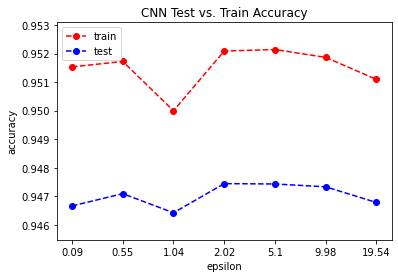

In [ ]:
# main experiment loop runs for eps = 0.1, 0.5, 1, 2, 5, 10 and 20
# send noise multiplier as argument to runTraining

#epsilon = 0.1
runTraining(2.65)

#epsilon = 0.5
runTraining(1.09)

#epsilon = 1
runTraining(0.82)

#epsilon = 2
runTraining(0.64)

#epsilon = 5
runTraining(0.484)

# epsilon = 10
runTraining(0.412)

# epsilon = 20
runTraining(0.355)

print(eps_values)

testVsTrainAccFigure("CNN")

In [ ]:
dir='/content/drive/MyDrive/DGA_PPML/'
dir_model = dir + 'mlp_binary_all/'
dataset='all_dataset'

In [ ]:
model_loss = []
model_val_loss = []
loss_delta = []

model_acc = []
model_val_acc = []
acc_delta = []

eps_values = []

In [ ]:
# MLP training model
def train():

  optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  loss = tf.keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.0, axis=-1,
      reduction=tf.losses.Reduction.NONE, name='binary_crossentropy'
  )

  # MODEL
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=128, output_dim=128, input_length=64))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
  #microbatch must be divisible by units
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) 
  # model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])
  model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])

  hist = model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.2, epochs=epochs, shuffle=True)
  
  score_train, acc_train = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1)
  score_test, acc_test = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

  model_loss.append(score_train)
  model_val_loss.append(score_test)
  model_acc.append(acc_train)
  model_val_acc.append(acc_test)



  modelo_json = model.to_json()
  with open(dir_model+"model_mlp_binary.json", "w") as json_file:
    json_file.write(modelo_json)
  model.save_weights(dir_model+"model_mlp_binary.h5")


  inputP0=dir_model+'input-P0-0_mlp_binary'
  os.system("echo \" \" > "+ inputP0)
  i=0
  for w in model.get_weights():
    try:
      if i==0:
        w1 = []
        for filter in range(32):
          weights_cnn1 = []
          for k in range(10):
            weights_cnn1.append(w[k][0][filter])
          w1.append(weights_cnn1)
        w = np.asarray(w1)
      arq=dir_model+"weights"+str(i)+".csv"
      np.savetxt(arq, w.ravel(), delimiter=" ",fmt='%f')
      os.system("cat "+arq+" >> "+ inputP0)
      print(i, np.array(w).shape, np.ravel(w).shape)
      i=i+1
    except:
      print('erro',w.shape)



DP-SGD with sampling rate = 0.00792% and noise_multiplier = 2.79 iterated over 378750 steps satisfies differential privacy with eps = 0.0874 and delta = 6.188118811881188e-07.
The optimal RDP order is 128.0.
3157/3157 [==============================] - 7s 2ms/step - loss: 0.2149 - accuracy: 0.9597
DP-SGD with sampling rate = 0.00792% and noise_multiplier = 1.09 iterated over 378750 steps satisfies differential privacy with eps = 0.547 and delta = 6.188118811881188e-07.
The optimal RDP order is 21.0.
3157/3157 [==============================] - 7s 2ms/step - loss: 0.2087 - accuracy: 0.9583
DP-SGD with sampling rate = 0.00792% and noise_multiplier = 0.82 iterated over 378750 steps satisfies differential privacy with eps = 1.04 and delta = 6.188118811881188e-07.
The optimal RDP order is 12.0.
Epoch 1/30
3157/3157 [==============================] - 7s 2ms/step - loss: 0.2147 - accuracy: 0.9594
erro (128, 128)
erro (8192, 1024)
erro (1024,)
erro (1024, 1)
erro (1,)
DP-SGD with sampling rate

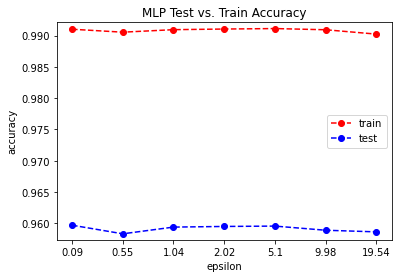

In [ ]:
# main experiment loop runs for eps = 0.1, 0.5, 1, 2, 5, 10 and 20

#epsilon = 0.1
runTraining(2.79)

#epsilon = 0.5
runTraining(1.09)

#epsilon = 1
runTraining(0.82)

#epsilon = 2
runTraining(0.64)

#epsilon = 5
runTraining(0.484)

# epsilon = 10
runTraining(0.412)

# epsilon = 20
runTraining(0.355)

print(eps_values)

testVsTrainAccFigure("MLP")


In [ ]:
dir='/content/drive/MyDrive/DGA_PPML/'
dir_model = dir + 'lstm_binary_all/'
dataset='all_dataset'

In [ ]:
model_loss = []
model_val_loss = []
loss_delta = []

model_acc = []
model_val_acc = []
acc_delta = []

eps_values = []

batch_size = 800
num_microbatches = 8
epochs = 20


In [ ]:
#LSTM training model

def train():
  
  optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  loss = tf.keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.0, axis=-1,
      reduction=tf.losses.Reduction.NONE, name='binary_crossentropy'
  )

  # MODEL
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=128, output_dim=128, input_length=64))
  model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(1,64)))
  model.add(tf.keras.layers.LSTM(units=32))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
  # model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])
  model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])
  # print(model.summary())

  hist = model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.2, epochs=epochs, shuffle=True)

  score_train, acc_train = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1)
  score_test, acc_test = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

  model_loss.append(score_train)
  model_val_loss.append(score_test)
  model_acc.append(acc_train)
  model_val_acc.append(acc_test)


  modelo_json = model.to_json()
  with open(dir_model+"model_lstm_binary.json", "w") as json_file:
    json_file.write(modelo_json)
  model.save_weights(dir_model+"model_lstm_binary.h5")


  inputP0=dir_model+'input-P0-0_lstm_binary'
  os.system("echo \" \" > "+ inputP0)
  i=0
  for w in model.get_weights():
    try:
      if i==0:
        w1 = []
        for filter in range(32):
          weights_cnn1 = []
          for k in range(10):
            weights_cnn1.append(w[k][0][filter])
          w1.append(weights_cnn1)
        w = np.asarray(w1)
      arq=dir_model+"weights"+str(i)+".csv"
      np.savetxt(arq, w.ravel(), delimiter=" ",fmt='%f')
      os.system("cat "+arq+" >> "+ inputP0)
      print(i, np.array(w).shape, np.ravel(w).shape)
      i=i+1
    except:
      print('erro',w.shape)




DP-SGD with sampling rate = 0.0495% and noise_multiplier = 3.9 iterated over 40400 steps satisfies differential privacy with eps = 0.11 and delta = 6.188118811881188e-07.
The optimal RDP order is 128.0.
505/505 [==============================] - 3s 5ms/step - loss: 0.1300 - accuracy: 0.9470
DP-SGD with sampling rate = 0.0495% and noise_multiplier = 0.735 iterated over 40400 steps satisfies differential privacy with eps = 2.1 and delta = 6.188118811881188e-07.
The optimal RDP order is 7.0.
505/505 [==============================] - 3s 5ms/step - loss: 0.1305 - accuracy: 0.9470
DP-SGD with sampling rate = 0.0495% and noise_multiplier = 0.39 iterated over 40400 steps satisfies differential privacy with eps = 20 and delta = 6.188118811881188e-07.
The optimal RDP order is 2.0.
505/505 [==============================] - 3s 5ms/step - loss: 0.1288 - accuracy: 0.9484
erro (128, 128)
erro (128, 128)
erro (32, 128)
erro (128,)
erro (32, 128)
erro (32, 128)
erro (128,)
erro (32, 1)
erro (1,)


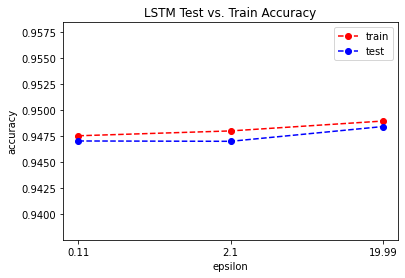

In [ ]:
# main experiment loop runs for eps = 0.1, 0.5, 1, 2, 5, 10 and 20
# note the the accuracy of this model can likely be much higher if runs longer

runTraining(3.9)
# runTraining(1.31)
# runTraining(0.95)
runTraining(0.735)
# runTraining(0.55)
# runTraining(0.46)
runTraining(0.39)

testVsTrainAccFigure("LSTM")
